#INITIAL SET UP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#DATA LOADING

In [ ]:
# Load the dataset
dataset = np.load('/content/drive/MyDrive/Challenge1/extracted_data/public_data.npz', allow_pickle=True)

print(dataset.files)

['data', 'labels']


In [ ]:
# Extract the arrays from the data
data = dataset['data']
labels = dataset['labels']

# Convert data and labels values into the correct data_type
data = np.array(data, dtype=np.uint8)

print(data.shape) #the images
print(labels.shape)

(5200, 96, 96, 3)
(5200,)


# DATA SET PREPARATION

In [ ]:
# Remove duplicates
def get_image_hash(image):
    # Convert image into a string
    image_string = image.tobytes()

    # Calculate the sum of byte values
    hash_value = sum(image_string)

    return hash_value

# Compute hash for each image
hashes = np.array([get_image_hash(image) for image in data])

# Find unique hashes and their indices
unique_hashes, indices = np.unique(hashes, return_index=True)

# Select the unique images and their corresponding labels
data_unique = data[indices]
labels_unique = labels[indices]


print(f"Original dataset size: {data.shape[0]}")
print(f"Unique dataset size: {data_unique.shape[0]}")

Original dataset size: 5200
Unique dataset size: 4849


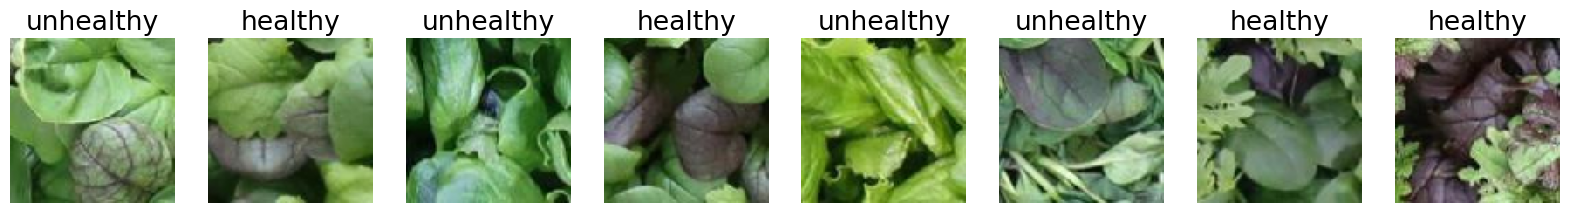

In [ ]:
# Randomize the choice of images at each run
seed = random.randint(0, 1000)
random.seed(seed)
fig, ax = plt.subplots(1, 8, figsize=(20, 20))
for i in range(8):
    random_index = random.randint(0, data_unique.shape[0])
    ax[i].imshow(data_unique[random_index])
    ax[i].set_title(labels_unique[random_index])
    ax[i].axis('off')
plt.show()

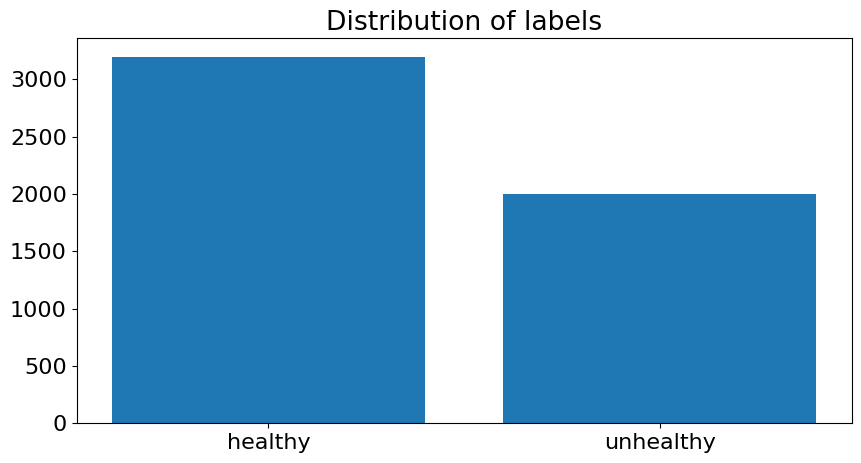

In [ ]:
from collections import Counter

counter_labels = Counter(labels)
labels_count, counts = zip(*counter_labels.items())

plt.figure(figsize=(10, 5))
plt.bar(labels_count, counts)
plt.title('Distribution of labels')
plt.show()

In [ ]:
# UPSAMPLING
# Find the indices of the healthy and unhealthy images
healthy_indices = np.where(labels_unique == 'healthy')[0]
unhealthy_indices = np.where(labels_unique == 'unhealthy')[0]

# Determine the number of images to sample from the unhealthy class to match the healthy class
num_samples = len(healthy_indices)

random_unhealthy_indices = np.random.choice(unhealthy_indices, size=(num_samples - len(unhealthy_indices)), replace=True)
random_unhealthy_images = data_unique[random_unhealthy_indices]
random_unhealthy_labels = labels_unique[random_unhealthy_indices]

# perform horizontal and vertical flipping and a 0.3 angle rotation on random_unhealthy_images
flip = tf.keras.Sequential([tfkl.RandomFlip("horizontal"), tfkl.RandomFlip("vertical"), tfkl.RandomRotation(0.3)])
random_unhealthy_images = np.array(flip(random_unhealthy_images), dtype=np.uint8)


# Concatenate the random unhealthy images and labels with the labels_unique and data_unique
data_balanced = np.concatenate([data_unique, random_unhealthy_images])
labels_balanced = np.concatenate([labels_unique, random_unhealthy_labels])

# Shuffle the data and labels so that the labels still correspond to the data
indices = np.arange(data_balanced.shape[0])
np.random.shuffle(indices)
data_balanced = data_balanced[indices]
labels_balanced = labels_balanced[indices]

print(data_balanced.shape)
print(labels_balanced.shape)

(6120, 96, 96, 3)
(6120,)


In [ ]:
# normalize the data
data_balanced = data_balanced.astype('float32') / 255.0

In [ ]:
# Convert labels to one-hot encoding
label_mapping = {'healthy': 0, 'unhealthy': 1}
numeric_labels = [label_mapping[label] for label in labels_balanced]
one_hot_labels = np.array(numeric_labels)

# DATA SPLITTING

In [ ]:
# Split the data into train_val and test sets with stratification to ensure that the distribution of labels is the same in both sets
train_val_data, test_data, train_val_labels, test_labels = train_test_split(data_balanced, one_hot_labels, test_size=0.20, random_state=seed, stratify=one_hot_labels)
#train_data, val_data, train_labels, val_labels = train_test_split(data_balanced, one_hot_labels, test_size=0.20, random_state=seed, stratify=one_hot_labels)


# Further split the train_val set into train and val sets with stratification
train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=len(test_data), random_state=seed, stratify=train_val_labels)

# Print the shape of the train, val and test sets
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
#print(test_data.shape, test_labels.shape)

(3672, 96, 96, 3) (3672,)
(1224, 96, 96, 3) (1224,)


# MOBILENET MODEL

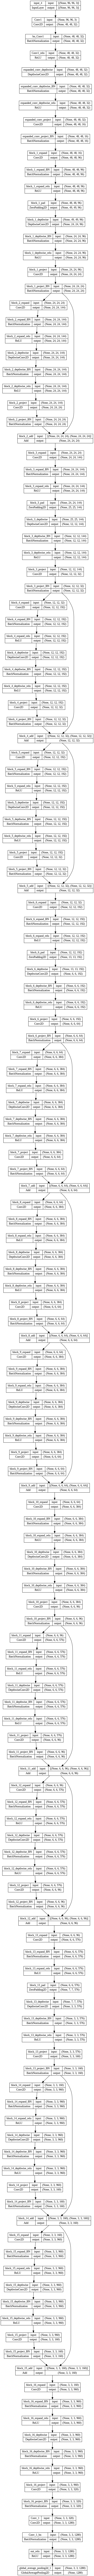

In [ ]:
# Define the input shape, output shape, batch size and the number of epochs
input_shape = train_data.shape[1:]
output_shape = len(np.unique(one_hot_labels))
batch_size = 32
epochs = 200

# Train the model with mobilenetv2 (with no data augmentation) WHY AVG AND NOT MAX?? TO TRY
mobile_model = tfk.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile_model, show_shapes=True)

In [ ]:
# Create an input layer with the same shape as the mobilenetv2 input
inputs = tfkl.Input(shape=input_shape)
x = mobile_model(inputs, training=True)
outputs = tfkl.Dense( 1, activation='sigmoid')(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name = 'model')
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


## Model training

In [ ]:
# Train the model
history = model.fit(
    x = preprocess_input(train_data),
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(val_data), val_labels),
    shuffle = True,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=12, restore_best_weights=True)]
).history

Epoch 1/200
115/115 [==============================] - 32s 65ms/step - loss: 0.4816 - accuracy: 0.7832 - val_loss: 0.3966 - val_accuracy: 0.8170
Epoch 2/200
115/115 [==============================] - 5s 45ms/step - loss: 0.2661 - accuracy: 0.8859 - val_loss: 0.3401 - val_accuracy: 0.8562
Epoch 3/200
115/115 [==============================] - 5s 47ms/step - loss: 0.2218 - accuracy: 0.9158 - val_loss: 0.3917 - val_accuracy: 0.8448
Epoch 4/200
115/115 [==============================] - 5s 47ms/step - loss: 0.1680 - accuracy: 0.9300 - val_loss: 0.4370 - val_accuracy: 0.8423
Epoch 5/200
115/115 [==============================] - 5s 45ms/step - loss: 0.1356 - accuracy: 0.9466 - val_loss: 0.4196 - val_accuracy: 0.8391
Epoch 6/200
115/115 [==============================] - 6s 52ms/step - loss: 0.1317 - accuracy: 0.9477 - val_loss: 0.4342 - val_accuracy: 0.8472
Epoch 7/200
115/115 [==============================] - 5s 44ms/step - loss: 0.0998 - accuracy: 0.9632 - val_loss: 0.6154 - val_accuracy

## Model Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(preprocess_input(test_data), test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")
# evaluate f1 score, precision and recall
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred = model.predict(preprocess_input(test_data))
y_pred = np.where(y_pred > 0.5, 1, 0)
print(f"F1 score: {f1_score(test_labels, y_pred):.2f}")
print(f"Precision: {precision_score(test_labels, y_pred):.2f}")
print(f"Recall: {recall_score(test_labels, y_pred):.2f}")

39/39 - 1s - loss: 0.6390 - accuracy: 0.8652 - 676ms/epoch - 17ms/step
Test accuracy: 0.87
39/39 [==============================] - 2s 14ms/step
F1 score: 0.87
Precision: 0.86
Recall: 0.87


In [ ]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='train_accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MODEL WITH DATA AUGMENTATION

In [ ]:
# create data augmentation pipeline
data_augmentation = tfk.Sequential([
    #tfkl.Rescaling(1./255),
    #tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    #tfkl.RandomBrightness(0.2, seed=seed),
    #tfkl.RandomContrast(0.2, seed=seed)
], name = "preprocessing")

RandomFlip e RandomTranslation -> 0.87 test

In [ ]:
# create mobile_model with augmentation
inputs = tfkl.Input(shape=input_shape)
data_augmentation = data_augmentation(inputs)
x = mobile_model(data_augmentation, training=True)
outputs = tfkl.Dense(1, activation='sigmoid')(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name = 'model')
##TODO CHANGE TYPE OF OPTIMIZER
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.legacy.Adam(), metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    x = preprocess_input(train_data),
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(val_data), val_labels),
    shuffle = True,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Save the trained model
model.save('/content/drive/MyDrive/Challenge1/Challenge1_Filippo/mobilenetv2-normalized')

Epoch 1/200
115/115 [==============================] - 176s 1s/step - loss: 0.6470 - accuracy: 0.7078 - val_loss: 0.4454 - val_accuracy: 0.7819
Epoch 2/200
115/115 [==============================] - 163s 1s/step - loss: 0.4388 - accuracy: 0.7865 - val_loss: 0.3898 - val_accuracy: 0.8382
Epoch 3/200
115/115 [==============================] - 162s 1s/step - loss: 0.3841 - accuracy: 0.8303 - val_loss: 0.3410 - val_accuracy: 0.8472
Epoch 4/200
115/115 [==============================] - 156s 1s/step - loss: 0.3487 - accuracy: 0.8445 - val_loss: 0.3279 - val_accuracy: 0.8497
Epoch 5/200
115/115 [==============================] - 150s 1s/step - loss: 0.3452 - accuracy: 0.8519 - val_loss: 0.3122 - val_accuracy: 0.8693
Epoch 6/200
115/115 [==============================] - 150s 1s/step - loss: 0.3355 - accuracy: 0.8592 - val_loss: 0.3086 - val_accuracy: 0.8709
Epoch 7/200
115/115 [==============================] - 156s 1s/step - loss: 0.3031 - accuracy: 0.8785 - val_loss: 0.3111 - val_accuracy:

## Model Evaluation

In [ ]:
del model
model = tfk.models.load_model('/content/drive/MyDrive/Challenge1/Challenge1_Filippo/mobilenetv2-Neuromasters')

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(preprocess_input(test_data), test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")
# evaluate f1 score, precision and recall
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred = model.predict(preprocess_input(test_data))
y_pred = np.where(y_pred > 0.5, 1, 0)
print(f"F1 score: {f1_score(test_labels, y_pred):.2f}")
print(f"Precision: {precision_score(test_labels, y_pred):.2f}")
print(f"Recall: {recall_score(test_labels, y_pred):.2f}")

39/39 - 1s - loss: 0.2595 - accuracy: 0.9044 - 803ms/epoch - 21ms/step
Test accuracy: 0.90
39/39 [==============================] - 1s 16ms/step
F1 score: 0.90
Precision: 0.90
Recall: 0.91


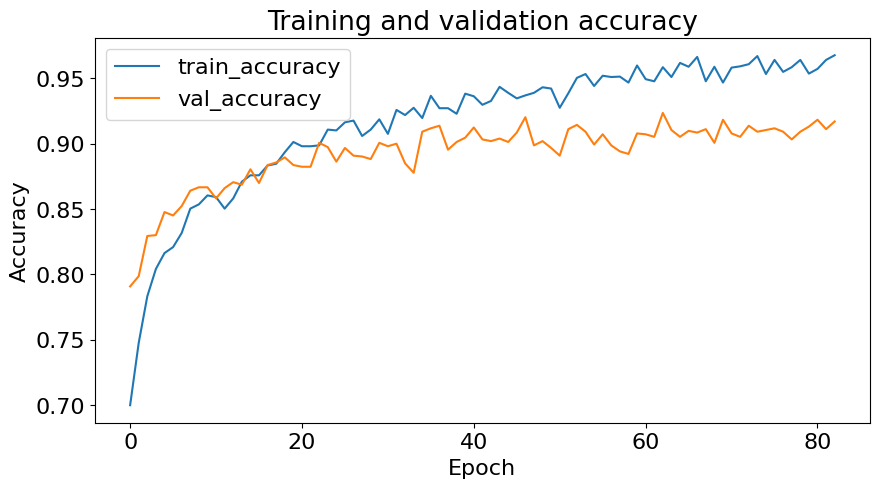

In [ ]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='train_accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MODEL WITH FINE TUNING

In [ ]:
# Delete and reload the model
del ft_model
ft_model = tfk.models.load_model('/content/drive/MyDrive/Challenge1/Challenge1_Filippo/mobilenetv2-balanced_augmentation')

In [ ]:
# Set all the layers to trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True

In [ ]:
# Freeze the first 100 layers
N = 100
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

In [ ]:
# Train the model
ft_history = ft_model.fit(
    x = preprocess_input(train_data),
    y = train_labels,
    batch_size = 32,
    epochs = epochs,
    validation_data = (preprocess_input(val_data), val_labels),
    shuffle = True,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
96/96 [==============================] - 27s 76ms/step - loss: 0.6980 - accuracy: 0.5013 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 2/200
96/96 [==============================] - 4s 45ms/step - loss: 0.6948 - accuracy: 0.4810 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/200
95/96 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5026

KeyboardInterrupt: ignored